<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
!pip install -q aequitas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()

# Módulos para evaluar rendimiento
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Módulos para evaluar equidad
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# Se monta el Google Drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/TFG/')
from TFG_Comun import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definición de funciones

In [3]:
# Función para mostrar la matriz de confusión
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))

    x_axis_labels = ['No Melanoma', 'Melanoma']
    y_axis_labels = ['No Melanoma', 'Melanoma']

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                linewidths=1, linecolor='black',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels)

    plt.ylabel('Diagnóstico real')
    plt.xlabel('Predicción del modelo')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])

## Preparación de los dataframes

In [4]:
# Fichero con las predicciones del modelo
file_predictions = TFG_PREDICCIONES
# Fichero de metadatos de los/las pacientes
file_metadata = TFG_METADATA

# Carga del fichero con las predicciones (probabilidades) del modelo
df_predictions = pd.read_csv(file_predictions)

# Carga del fichero con los metadatos de los/las pacientes
df_metadata = pd.read_csv(file_metadata)
# Se cambia el nombre de la columna del diagnóstico real 
# en el dataframe de predicciones
df_predictions.rename(columns = {'target':'target_p'}, inplace = True)

print("Número de registros en fichero de metadatos:", len(df_metadata))
print("Número de registros en fichero de predicciones del conjunto de datos de prueba:", len(df_predictions))

Número de registros en fichero de metadatos: 23257
Número de registros en fichero de predicciones del conjunto de datos de prueba: 3483


In [5]:
# Se combinan (inner join) ambos dataframes por la columna image_name
df_total = pd.merge(df_metadata, df_predictions, on='image_name')

In [6]:
# Se crea una columna con la predicción en binario
df_total['prediction_binary'] = np.where(df_total['prediction'] > 0.5, 1, 0)

In [7]:
# Se comprueba que las etiquetas del fichero de metadados 
# y del fichero de predicciones son la misma 
print(len(df_total[df_total['target']!=df_total['target_p']]))

0


In [8]:
# Se muestran los primeros registros del dataframe combinado
df_total.head(10)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tipo_ITA,age_group_approx,target_p,prediction,prediction_binary
0,ISIC_0000001,female,30.0,anterior torso,NV,benign,0,6,"(15, 30]",0,4.549374e-04,0
1,ISIC_0000003,male,30.0,upper extremity,NV,benign,0,1,"(15, 30]",0,5.545164e-04,0
2,ISIC_0000009,female,30.0,anterior torso,NV,benign,0,1,"(15, 30]",0,1.428698e-08,0
3,ISIC_0000016,female,55.0,anterior torso,NV,benign,0,6,"(45, 60]",0,6.332980e-05,0
4,ISIC_0000072,male,85.0,posterior torso,NV,benign,0,1,"(75, 90]",0,5.571408e-01,1
5,ISIC_0000157,male,60.0,upper extremity,MEL,malignant,1,1,"(45, 60]",1,7.033381e-01,1
6,ISIC_0000167,male,40.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,2.205573e-01,0
7,ISIC_0000172,female,35.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,9.999999e-01,1
8,ISIC_0000198,male,65.0,lower extremity,NV,benign,0,2,"(60, 75]",0,1.134982e-03,0
9,ISIC_0000199,male,20.0,upper extremity,NV,benign,0,1,"(15, 30]",0,7.123548e-06,0


## Evaluación del rendimiento

In [9]:
# Diagnóstico real
y_true = list(df_total['target'])
# Diagnóstico predicho (probabilidad)
y_pred = list(df_total['prediction'])
# Diagnóstico predicho (binario)
y_pred_binary = list(df_total['prediction_binary'])

### Curva ROC

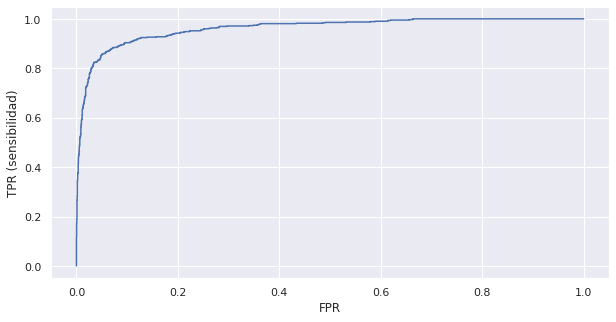

AUC: 0.961


In [10]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR (sensibilidad)")
plt.show()

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))



In [11]:
auc_roc = roc_auc_score(y_true, y_pred)
print("AUC ROC: {0:.3f}".format(auc_roc))
auc_pr = average_precision_score(y_true, y_pred)
print("AUC PR: {0:.3f}".format(auc_pr))

AUC ROC: 0.961
AUC PR: 0.886


### Curva Precisión-Sensibilidad

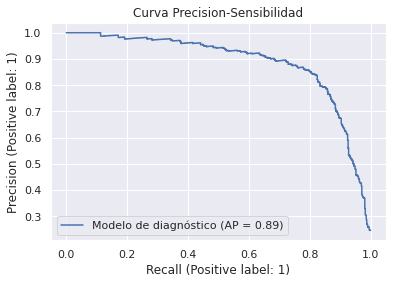

In [12]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, 
                                                  name="Modelo de diagnóstico");
_ = display.ax_.set_title("Curva Precision-Sensibilidad");

### Matriz de confusión

Verdadero negativo:  2770
Falso positivo:  92
Falso negativo:  121
Vardadero positivo:  500


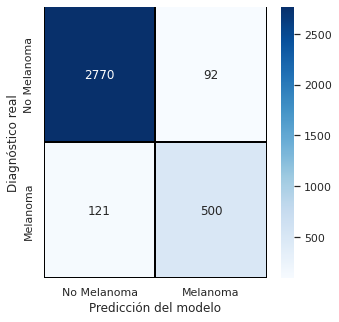

In [13]:
# Matriz de confusión
show_confusion_matrix(y_true, y_pred_binary)

In [14]:
# Métricas precisión, sensibilidad y F1
metrics = precision_recall_fscore_support(y_true, y_pred_binary)
print("Precisión:", round(metrics[0][1],3))
print("Sensibilidad:", round(metrics[1][1],3))
print("Puntuación F1:", round(metrics[2][1],3))

Precisión: 0.845
Sensibilidad: 0.805
Puntuación F1: 0.824


## Evaluación de la equidad

In [15]:
# Se crea el dataframe que se va a utilizar para la evaluación de la equidad
df_fairness = df_total[df_total['sex']!='unknown'].copy()

# Se necesitan tener las columnas label_value y score
df_fairness = df_fairness.rename(columns={"target": "label_value", "prediction_binary": "score"})
df_fairness["age_group_approx"] = df_fairness["age_group_approx"].astype(str)
df_fairness["tipo_ITA"] = df_fairness["tipo_ITA"].astype(str)
# Se eliminan columnas innecesarias,
df_fairness = df_fairness.drop(['image_name', 'benign_malignant', 'diagnosis', 
                          'age_approx', 'anatom_site_general_challenge',
                          'target_p',
                          'prediction'], axis=1)

df_fairness.to_csv("TFG_equidad.csv", index=False)
df_fairness.head()

,sex,label_value,tipo_ITA,age_group_approx,score
0,female,0,6,"(15, 30]",0
1,male,0,1,"(15, 30]",0
2,female,0,1,"(15, 30]",0
3,female,0,6,"(45, 60]",0
4,male,0,1,"(75, 90]",1


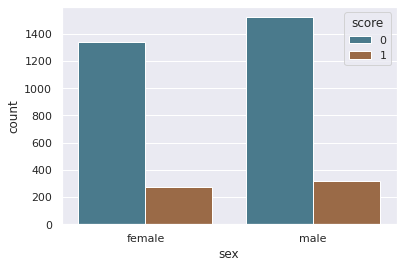

In [16]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_sex = sns.countplot(x="sex", hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

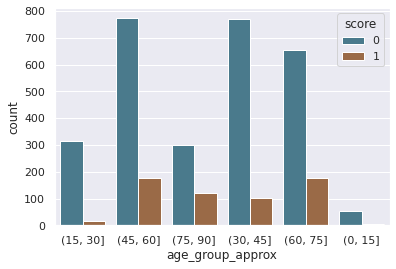

In [17]:
by_age = sns.countplot(x="age_group_approx", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

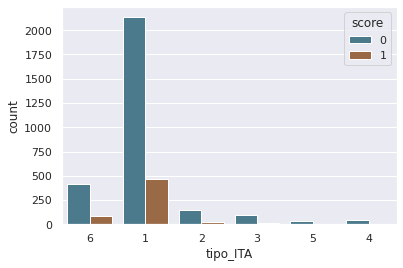

In [18]:
by_ITA = sns.countplot(x="tipo_ITA", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

In [19]:
g = Group()
xtab, _ = g.get_crosstabs(df_fairness)

In [20]:
absolute_metrics = g.list_absolute_metrics(xtab)

## Cálculo de métricas de equidad:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |

In [21]:
data_equity = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
data_equity

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,female,0.81,0.97,0.04,0.15,0.03,0.19,0.96,0.85,0.46,0.17,0.18
1,sex,male,0.80,0.97,0.04,0.16,0.03,0.20,0.96,0.84,0.54,0.17,0.18
2,tipo_ITA,1,0.81,0.96,0.04,0.16,0.04,0.19,0.96,0.84,0.79,0.18,0.19
3,tipo_ITA,2,0.92,0.97,0.01,0.14,0.03,0.08,0.99,0.86,0.05,0.16,0.15
4,tipo_ITA,3,0.69,0.98,0.04,0.18,0.02,0.31,0.96,0.82,0.02,0.11,0.13
5,tipo_ITA,4,1.00,0.96,0.00,0.40,0.04,0.00,1.00,0.60,0.01,0.10,0.06
6,tipo_ITA,5,0.50,1.00,0.03,0.00,0.00,0.50,0.97,1.00,0.00,0.03,0.06
7,tipo_ITA,6,0.80,0.98,0.04,0.11,0.02,0.20,0.96,0.89,0.14,0.16,0.18
8,age_group_approx,"(0, 15]",0.00,0.95,0.02,1.00,0.05,1.00,0.98,0.00,0.01,0.05,0.02
9,age_group_approx,"(15, 30]",0.63,0.99,0.02,0.25,0.01,0.37,0.98,0.75,0.03,0.05,0.06


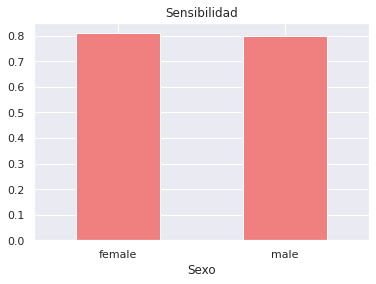

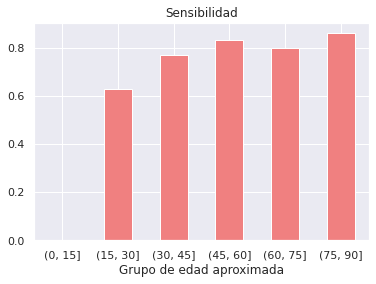

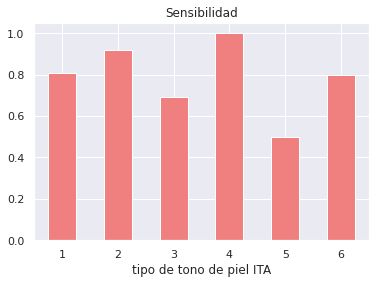

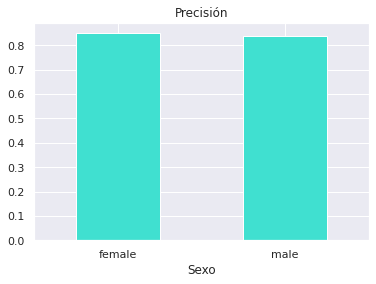

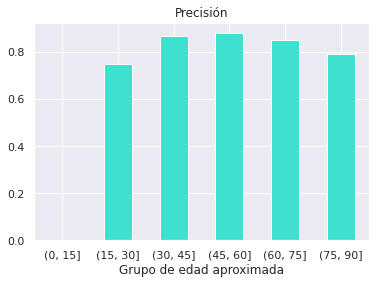

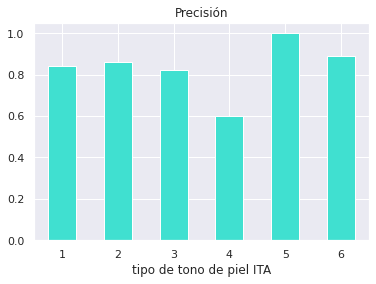

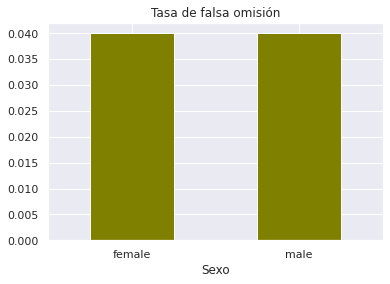

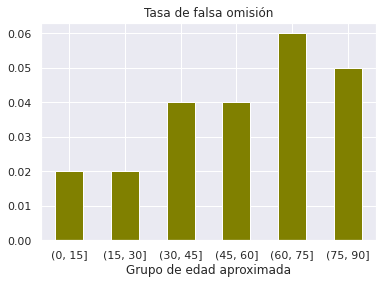

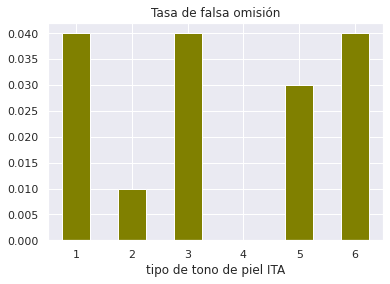

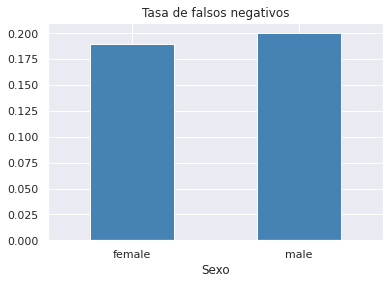

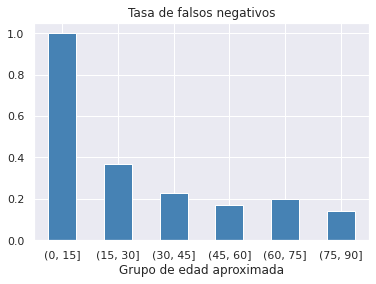

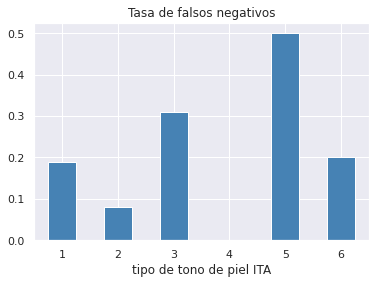

In [22]:
# Representación gráfica
col_bars = {
    "sex": "Sexo",
    "age_group_approx": "Grupo de edad aproximada",
    "tipo_ITA": "tipo de tono de piel ITA"
}

# Sensibilidad
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'tpr']]\
                                                    .plot.bar(x="attribute_value", y="tpr",
                                                              legend=None,
                                                              rot=0, color="lightcoral");
  ax.set_title("Sensibilidad")
  ax.set_xlabel(value);
  plt.show();       


# Precisión
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'precision']]\
                                                    .plot.bar(x="attribute_value", y="precision",
                                                              legend=None,
                                                              rot=0, color="turquoise");
  ax.set_title("Precisión")
  ax.set_xlabel(value);
  plt.show();  

# Tasa de falsa omisión FOR
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'for']]\
                                                    .plot.bar(x="attribute_value", y="for",
                                                              legend=None,
                                                              rot=0, color="olive");
  ax.set_title("Tasa de falsa omisión")
  ax.set_xlabel(value);
  plt.show();  

# Tasa de falsos negativos FNR
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'fnr']]\
                                                    .plot.bar(x="attribute_value", y="fnr",
                                                              legend=None,
                                                              rot=0, color="steelblue");
  ax.set_title("Tasa de falsos negativos")
  ax.set_xlabel(value);
  plt.show(); 


In [23]:
b = Bias()
# Se toma como referencia hombres entre 30 y 45 años de tono de piel clara
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fairness, 
                                        ref_groups_dict={'sex':'male', 
                                                         'tipo_ITA': '1',
                                                         'age_group_approx':'(30, 45]'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,591,sex,female,0.813380,0.968373,0.039582,0.153846,0.031627,0.186620,0.960418,0.846154,273,1339,0.461929,0.169355,42,53,1286,231,284,1328,1612,3452,0.176179,False,False,0.978462,male,False,0.944409,male,False,0.912780,male,False,0.952590,male,False,1.003954,male,False,0.858491,male,False,0.979915,male,False,1.004018,male,False,1.001628,male,False,1.013690,male,False
1,0,binary 0/1,591,sex,male,0.802395,0.966799,0.043364,0.157233,0.033201,0.197605,0.956636,0.842767,318,1522,0.538071,0.172826,50,66,1456,268,334,1506,1840,3452,0.181522,False,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False
2,0,binary 0/1,591,tipo_ITA,1,0.805785,0.964539,0.044049,0.161290,0.035461,0.194215,0.955951,0.838710,465,2134,0.786802,0.178915,75,94,2040,390,484,2115,2599,3452,0.186225,False,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False
3,0,binary 0/1,591,tipo_ITA,2,0.923077,0.972789,0.013793,0.142857,0.027211,0.076923,0.986207,0.857143,28,145,0.047377,0.161850,4,2,143,24,26,147,173,3452,0.150289,False,False,0.885714,1,False,0.396072,1,False,0.313133,1,False,0.767347,1,False,1.031650,1,False,0.060215,1,False,0.904618,1,False,1.021978,1,False,1.008553,1,False,1.145562,1,False
4,0,binary 0/1,591,tipo_ITA,3,0.692308,0.977528,0.043956,0.181818,0.022472,0.307692,0.956044,0.818182,11,91,0.018613,0.107843,2,4,87,9,13,89,102,3452,0.127451,False,False,1.127273,1,False,1.584288,1,False,0.997896,1,False,0.633708,1,False,1.000097,1,False,0.023656,1,False,0.602762,1,False,0.975524,1,False,1.013467,1,False,0.859172,1,False
5,0,binary 0/1,591,tipo_ITA,4,1.000000,0.957447,0.000000,0.400000,0.042553,0.000000,1.000000,0.600000,5,45,0.008460,0.100000,2,0,45,3,3,47,50,3452,0.060000,True,False,2.480000,1,False,0.000000,1,False,0.000000,1,False,1.200000,1,False,1.046078,1,False,0.010753,1,False,0.558925,1,False,0.715385,1,False,0.992647,1,False,1.241026,1,False
6,0,binary 0/1,591,tipo_ITA,5,0.500000,1.000000,0.031250,0.000000,0.000000,0.500000,0.968750,1.000000,1,32,0.001692,0.030303,0,1,31,1,2,31,33,3452,0.060606,False,True,0.000000,1,None,2.574468,1,False,0.709441,1,False,0.000000,1,None,1.013388,1,False,0.002151,1,True,0.169371,1,True,1.192308,1,None,1.036765,1,None,0.620513,1,False
7,0,binary 0/1,591,tipo_ITA,6,0.800000,0.977778,0.043478,0.111111,0.022222,0.200000,0.956522,0.888889,81,414,0.137056,0.163636,9,18,396,72,90,405,495,3452,0.181818,False,False,0.688889,1,False,1.029787,1,False,0.987049,1,False,0.626667,1,False,1.000597,1,False,0.174194,1,False,0.914604,1,False,1.059829,1,False,1.013725,1,False,0.992821,1,False
8,0,binary 0/1,591,age_group_approx,"(0, 15]",0.000000,0.946429,0.018519,1.000000,0.053571,1.000000,0.981481,0.000000,3,54,0.005076,0.052632,3,1,53,0,1,56,57,3452,0.017544,True,False,7.769231,"(30, 45]",True,4.259259,"(30, 45]",False,0.527435,"(30, 45]",False,3.111264,"(30, 45]",True,1.017196,"(30, 45]",False,0.029703,"(30, 45]",False,0.453361,"(30, 45]",False,0.000000,"(30, 45]",True,0.963010,"(30, 45]",True,0

In [24]:
# Visualiza las métricas de equidad
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].round(2)

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,sex,female,0.98,0.94,0.91,0.95,1.00,0.86,0.98,1.00,...,False,False,False,False,False,False,False,False,False,False
1,sex,male,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,tipo_ITA,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
3,tipo_ITA,2,0.89,0.40,0.31,0.77,1.03,0.06,0.90,1.02,...,False,False,False,False,False,False,False,False,False,False
4,tipo_ITA,3,1.13,1.58,1.00,0.63,1.00,0.02,0.60,0.98,...,False,False,False,False,False,False,False,False,False,False
5,tipo_ITA,4,2.48,0.00,0.00,1.20,1.05,0.01,0.56,0.72,...,False,False,False,False,False,False,False,False,False,False
6,tipo_ITA,5,0.00,2.57,0.71,0.00,1.01,0.00,0.17,1.19,...,None,False,False,None,False,True,True,None,None,False
7,tipo_ITA,6,0.69,1.03,0.99,0.63,1.00,0.17,0.91,1.06,...,False,False,False,False,False,False,False,False,False,False
8,age_group_approx,"(0, 15]",7.77,4.26,0.53,3.11,1.02,0.03,0.45,0.00,...,True,False,False,True,False,False,False,True,True,False
9,age_group_approx,"(15, 30]",1.94,1.57,0.64,0.75,1.01,0.16,0.42,0.86,...,False,False,False,False,False,True,True,False,False,False


In [25]:
metrics = ['for']
disparity_tolerance = 1.25

In [26]:
bdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,591,sex,female,0.813380,0.968373,0.039582,0.153846,0.031627,...,False,1.004018,male,False,1.001628,male,False,1.013690,male,False
1,0,binary 0/1,591,sex,male,0.802395,0.966799,0.043364,0.157233,0.033201,...,False,1.000000,male,False,1.000000,male,False,1.000000,male,False
2,0,binary 0/1,591,tipo_ITA,1,0.805785,0.964539,0.044049,0.161290,0.035461,...,False,1.000000,1,False,1.000000,1,False,1.000000,1,False
3,0,binary 0/1,591,tipo_ITA,2,0.923077,0.972789,0.013793,0.142857,0.027211,...,False,1.021978,1,False,1.008553,1,False,1.145562,1,False
4,0,binary 0/1,591,tipo_ITA,3,0.692308,0.977528,0.043956,0.181818,0.022472,...,False,0.975524,1,False,1.013467,1,False,0.859172,1,False
5,0,binary 0/1,591,tipo_ITA,4,1.000000,0.957447,0.000000,0.400000,0.042553,...,False,0.715385,1,False,0.992647,1,False,1.241026,1,False
6,0,binary 0/1,591,tipo_ITA,5,0.500000,1.000000,0.031250,0.000000,0.000000,...,True,1.192308,1,None,1.036765,1,None,0.620513,1,False
7,0,binary 0/1,591,tipo_ITA,6,0.800000,0.977778,0.043478,0.111111,0.022222,...,False,1.059829,1,False,1.013725,1,False,0.992821,1,False
8,0,binary 0/1,591,age_group_approx,"(0, 15]",0.000000,0.946429,0.018519,1.000000,0.053571,...,False,0.000000,"(30, 45]",True,0.963010,"(30, 45]",True,0.000000,"(30, 45]",False
9,0,binary 0/1,591,age_group_approx,"(15, 30]",0.631579,0.987097,0.022364,0.250000,0.012903,...,True,0.860795,"(30, 45]",False,1.004391,"(30, 45]",False,0.825359,"(30, 45]",False


Este notebook está inspirado inspirado por:
COMPAS Analysis using Aequitas.
https://colab.research.google.com/github/dssg/aequitas/blob/update_compas_notebook/docs/source/examples/compas_demo.ipynb